# Sentiment Analysis of tweets related with Covid-19 vaccination

## Loading necessary libraries 

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
from sklearn import tree
from wordcloud import WordCloud # pip install wordcloud
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('vader_lexicon')
#import pydotplus (showing error)
import matplotlib.pyplot as plt
%pylab inline
import matplotlib.image as pltimg
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pylab as pl
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from nltk.sentiment.vader import SentimentIntensityAnalyzer # pip install vaderSentiment
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sudha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Populating the interactive namespace from numpy and matplotlib


## Extraction of data from kaggle in .csv format

In [2]:
# reading csv file into Dataframe
data = pd.read_csv("vaccination_all_tweets.csv",delimiter=',',)

FileNotFoundError: [Errno 2] No such file or directory: 'vaccination_all_tweets.csv'

## Data pre-processing and Data wrangling

In [3]:
#changing date format from date and time to only date
data['date'] = pd.to_datetime(data['date'], errors='coerce').dt.date

In [4]:
#Finding the details having highest number of followers
data.iloc[data.user_followers.idxmax()]

id                                                1420345793949573126
user_name                                                        NDTV
user_location                                                   India
user_description    Breaking news alerts from India.\n\nInstagram:...
user_created                                      2009-05-01 20:34:48
user_followers                                               15933831
user_friends                                                       14
user_favourites                                                     0
user_verified                                                    True
date                                                       2021-07-28
text                #VaccinateIndia | When will new #CovidVaccines...
hashtags            ['VaccinateIndia', 'CovidVaccines', 'SputnikV'...
source                                           Twitter Media Studio
retweets                                                            4
favorites           

In [5]:
#Finding the details having highest number of friends
data.iloc[data.user_friends.idxmax()]

id                                                1381598145969278980
user_name                                                    Sweasy26
user_location                                                   Earth
user_description    📝 Follow to learn the meaning of every 😂 #Emoj...
user_created                                      2009-09-27 12:34:55
user_followers                                                 677845
user_friends                                                   516578
user_favourites                                                    35
user_verified                                                   False
date                                                       2021-04-12
text                📉 Chart Decreasing Emoji #SputnikV\nhttps://t....
hashtags                                                 ['SputnikV']
source                                                Twitter Web App
retweets                                                            0
favorites           

In [6]:
#top 10 most retweeted tweets
data.sort_values(by='retweets', ascending=False)[['text', 'date', 'user_name', 'user_location', 
                                                'hashtags', 'retweets']].head(n=10)

text        date  \
68358  RDIF, Laboratorios Richmond launched productio...  2021-04-20   
46053  Why we need Two Doses of mRNA Vaccine 💉 #vacci...  2021-04-01   
54674  We completely reject the false and malicious r...  2021-04-08   
66822  ICMR study shows #COVAXIN neutralises against ...  2021-04-21   
68306  Argentine Health Minister @carlavizzotti and P...  2021-04-20   
76306  #Argentina's actor breaks into a live TV to sh...  2021-05-19   
17118  Got my jab. For the curious, it was #Covaxin. ...  2021-03-01   
53045  I see it’s going around with signature cropped...  2021-04-12   
75232  It’s 72 hours since @BharatBiotech announced t...  2021-05-17   
7126   New research published in Microbiology &amp; I...  2021-02-10   

                  user_name              user_location  \
68358             Sputnik V            Moscow, Russia    
46053        hotvickkrishna              Manhattan, NY   
54674         BharatBiotech           Hyderabad, India   
66822                  ICMR                  New Delhi   
68306             Sputnik V            Moscow, Russia    
76306             Sputnik V            Moscow, Russia    
17118     Dr. S. Jaishankar           New Delhi, India   
53045             dawnymock  Fredericton New Brunswick   
75232          B L Santhosh           New Delhi, India   
7126   Robert F. Kennedy Jr     Los Angles, California   

                                                hashtags  retweets  
68358                                       ['SputnikV']     11288  
46053  ['vaccines', 'COVID19', 'Pfizer', 'moderna', '...      7695  
54674                                                NaN      6018  
66822                                        ['COVAXIN']      4851  
68306                                                NaN      4105  
76306                          ['Argentina', 'SputnikV']      2550  
17118                                        ['Covaxin']      2360  
53045          ['covid', 'vaccine', 'pfizer', 'moderna']      2299  
75232                                                NaN      2294  
7126                                            ['mRNA']      2247

In [7]:
#Reduce data for analysis performance just for testing
#data = data.sample(n=50000)

In [8]:
#dropping unnecessary columns
data.drop(columns =['user_description', 'user_created', 'user_favourites', 'user_verified', 'source', 'favorites'])

id             user_name              user_location  \
0       1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1       1338158543359250433           Albert Fong          San Francisco, CA   
2       1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3       1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4       1337854064604966912  Citizen News Channel                        NaN   
...                     ...                   ...                        ...   
150984  1418384973887942658                Money9                        NaN   
150985  1418382970814009348                VaxBLR           Bengaluru, India   
150986  1418382926278844416                VaxBLR           Bengaluru, India   
150987  1418378595605618690            COVID News             Estados Unidos   
150988  1418366808982163458          Hernan 🇺🇾 🇦🇷                  Maldonado   

        user_followers  user_friends        date  \
0                  405          1692  2020-12-20   
1                  834           666  2020-12-13   
2                   10            88  2020-12-12   
3                49165          3933  2020-12-12   
4                  152           580  2020-12-12   
...                ...           ...         ...   
150984            4098             0  2021-07-23   
150985              12             0  2021-07-23   
150986              12             0  2021-07-23   
150987            3279          1474  2021-07-23   
150988             201           640  2021-07-23   

                                                     text  \
0       Same folks said daikon paste could treat a cyt...   
1       While the world has been on the wrong side of ...   
2       #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3       Facts are immutable, Senator, even when you're...   
4       Explain to me again why we need a vaccine @Bor...   
...                                                   ...   
150984  #Covidupdate | India reports over 34,861 cases...   
150985  18-44 #BBMP #Bengaluru #CovidVaccine Availabil...   
150986  18-44 #URBAN #Bengaluru #CovidVaccine Availabi...   
150987  18-44 #BBMP #Bengaluru #CovidVaccine Availabil...   
150988  @SantiCafiero @alferdez N E F A S T O\n#ElPeor...   

                                                 hashtags  retweets  \
0                                      ['PfizerBioNTech']         0   
1                                                     NaN         1   
2       ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...         0   
3                                                     NaN       446   
4          ['whereareallthesickpeople', 'PfizerBioNTech']         0   
...                                                   ...       ...   
150984  ['Covidupdate', 'COVID19', 'COVIDSecondWave', ...         0   
150985  ['BBMP', 'Bengaluru', 'CovidVaccine', 'COVISHI...         0   
150986  ['URBAN', 'Bengaluru', 'CovidVaccine', 'COVISH...         0   
150987  ['BBMP', 'Bengaluru', 'CovidVaccine', 'COVISHI...         0   
150988  ['ElPeorGobiernoDeLaHistoria', 'CFKLadronaDeLa...         0   

        is_retweet  
0            False  
1            False  
2            False  
3            False  
4            False  
...            ...  
150984       False  
150985       False  
150986       False  
150987       False  
150988       False  

[150989 rows x 10 columns]

In [9]:
# Check column data types
data.dtypes

id                   int64
user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
retweets             int64
favorites            int64
is_retweet            bool
dtype: object

In [10]:
# Changing the datatype of id from integer to object
data.id = data.id.astype(object)
# Finding the statistics summary by using "describe"
data.describe()

user_followers   user_friends  user_favourites       retweets  \
count    1.509890e+05  150989.000000     1.509890e+05  150989.000000   
mean     1.018201e+05    1014.397989     1.250401e+04       2.645683   
std      8.545705e+05    5078.393043     4.001760e+04      50.617582   
min      0.000000e+00       0.000000     0.000000e+00       0.000000   
25%      9.900000e+01      43.000000     5.800000e+01       0.000000   
50%      4.760000e+02     260.000000     1.167000e+03       0.000000   
75%      1.740000e+03     845.000000     7.750000e+03       1.000000   
max      1.593383e+07  516578.000000     1.221784e+06   11288.000000   

           favorites  
count  150989.000000  
mean       11.720536  
std       178.410271  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         2.000000  
max     25724.000000

In [11]:
#Suming the columns having null values within it
data.apply(lambda x:sum(x.isnull()), axis=0)

id                      0
user_name               0
user_location       48691
user_description    10433
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            28285
source                119
retweets                0
favorites               0
is_retweet              0
dtype: int64

### Pre-processing to remove unwanted characters and words

In [12]:
#Defining set containing all stopwords in English.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an','and','any','are', 'as', 'at', 'be', 
                'because', 'been', 'before', 'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do', 'does',
                'doing', 'down', 'during', 'each','few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he',
                'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into','is', 'it', 
                'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on',
                'once', 'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes",
                'should', "shouldve",'so', 'some', 'such', 't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them', 
                'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too','under', 'until',
                'up', 've', 'very', 'was', 'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom', 'why',
                'will', 'with', 'won', 'y', 'you', "youd","youll", "youre", "youve", 'your', 'yours', 'yourself', 
                'yourselves']

In [13]:
#Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

0    Same folks said daikon paste could treat cytok...
1    While world wrong side history year, hopefully...
2    #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3    Facts immutable, Senator, even you're not ethi...
4    Explain need vaccine @BorisJohnson @MattHancoc...
Name: text, dtype: object

In [14]:
#Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

150984    Covidupdate  India reports over 34861 cases la...
150985    1844 BBMP Bengaluru CovidVaccine Availability ...
150986    1844 URBAN Bengaluru CovidVaccine Availability...
150987    1844 BBMP Bengaluru CovidVaccine Availability ...
150988    SantiCafiero alferdez N E F A S T O ElPeorGobi...
Name: text, dtype: object

In [15]:
#Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

150984    Covidupdate  India reports over 3481 cases las...
150985    1844 BBMP Bengaluru CovidVaccine Availability ...
150986    1844 URBAN Bengaluru CovidVaccine Availability...
150987    1844 BBMP Bengaluru CovidVaccine Availability ...
150988    SantiCafiero alferdez N E F A S T O ElPeorGobi...
Name: text, dtype: object

In [16]:
#Cleaning and removing URL’s
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

150984    Covidupdate  India reports over 3481 cases las...
150985    1844 BBMP Bengaluru CovidVaccine Availability ...
150986    1844 URBAN Bengaluru CovidVaccine Availability...
150987    1844 BBMP Bengaluru CovidVaccine Availability ...
150988    SantiCafiero alferdez N E F A S T O ElPeorGobi...
Name: text, dtype: object

In [17]:
#Cleaning and removing Numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

150984    Covidupdate  India reports over  cases last  h...
150985     BBMP Bengaluru CovidVaccine Availability  AM ...
150986     URBAN Bengaluru CovidVaccine Availability  AM...
150987     BBMP Bengaluru CovidVaccine Availability PM F...
150988    SantiCafiero alferdez N E F A S T O ElPeorGobi...
Name: text, dtype: object

In [18]:
#Getting tokenization of tweet text
#tokenizer = RegexpTokenizer(r'w+')
#data['text'] = data['text'].apply(tokenizer.tokenize)
#data['text'].head()

In [19]:
#Applying Stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
#data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

0    Same folks said daikon paste could treat cytok...
1    While world wrong side history year hopefully ...
2    coronavirus SputnikV AstraZeneca PfizerBioNTec...
3    Facts immutable Senator even youre not ethical...
4    Explain need vaccine BorisJohnson MattHancock ...
Name: text, dtype: object

In [20]:
#Adding 4 new columns: negative, neutral, positive and compound using the lambda function.
data.loc[:, 'positive'] = data['text'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
data.loc[:, 'negative'] = data['text'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
data.loc[:, 'neutral'] = data['text'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
data.loc[:, 'compound'] = data['text'].apply(lambda x:analyzer.polarity_scores(x)['compound'])

In [21]:
data.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified        date  \
0             405          1692             3247          False  2020-12-20   
1             834           666              178          False  2020-12-13   
2              10            88              155          False  2020-12-12   
3           49165          3933            21853           True  2020-12-12   
4             152           580             1473          False  2020-12-12   

                                                text  \
0  Same folks said daikon paste could treat cytok...   
1  While world wrong side history year hopefully ...   
2  coronavirus SputnikV AstraZeneca PfizerBioNTec...   
3  Facts immutable Senator even youre not ethical...   
4  Explain need vaccine BorisJohnson MattHancock ...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  positive  negative  neutral  compound  
0         0          0       False     0.213     0.000    0.787    0.4019  
1         1          1       False     0.161     0.185    0.655   -0.1027  
2         0          0       False     0.154     0.000    0.846    0.2500  
3       446       2129       False     0.000     0.000    1.000    0.0000  
4         0          0       False     0.000     0.000    1.000    0.0000

In [22]:
#To view columns' name
data.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet', 'positive', 'negative', 'neutral', 'compound'],
      dtype='object')

In [23]:
pos_sum=data['positive'].sum()
neg_sum=data['negative'].sum()
neu_sum=data['neutral'].sum()
print(pos_sum)
print(neg_sum)
print(neu_sum)

13682.664
7000.616
130306.119


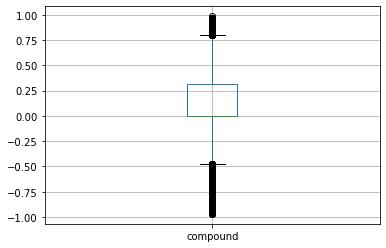

In [24]:
plt.boxplot = data.boxplot(column='compound')

In [25]:
data['label'] = np.select([(data['compound'] >=0.05),(data['compound'] <=-0.05)],['positive','negative'],default='neutral')

In [26]:
data.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified        date  \
0             405          1692             3247          False  2020-12-20   
1             834           666              178          False  2020-12-13   
2              10            88              155          False  2020-12-12   
3           49165          3933            21853           True  2020-12-12   
4             152           580             1473          False  2020-12-12   

   ...                                           hashtags  \
0  ...                                 ['PfizerBioNTech']   
1  ...                                                NaN   
2  ...  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...   
3  ...                                                NaN   
4  ...     ['whereareallthesickpeople', 'PfizerBioNTech']   

                source retweets  favorites  is_retweet  positive  negative  \
0  Twitter for Android        0          0       False     0.213     0.000   
1      Twitter Web App        1          1       False     0.161     0.185   
2  Twitter for Android        0          0       False     0.154     0.000   
3      Twitter Web App      446       2129       False     0.000     0.000   
4   Twitter for iPhone        0          0       False     0.000     0.000   

   neutral  compound     label  
0    0.787    0.4019  positive  
1    0.655   -0.1027  negative  
2    0.846    0.2500  positive  
3    1.000    0.0000   neutral  
4    1.000    0.0000   neutral  

[5 rows x 21 columns]

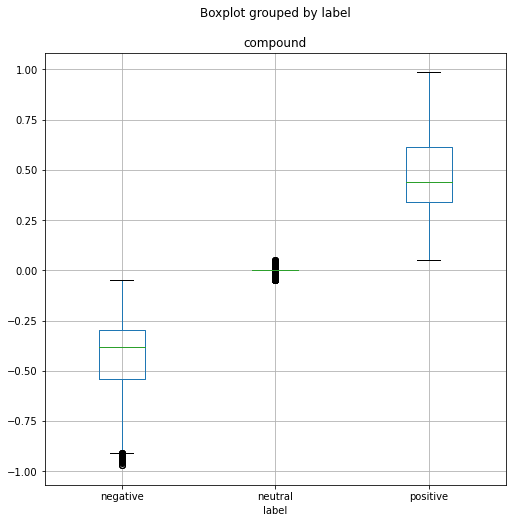

In [27]:
# to visualize categorical variables by using boxplots
plt.boxplot = data.boxplot(by='label', column='compound', figsize=(8,8))
#plt.boxplot = data.boxplot(column='neutral') for plotting of each category

In [28]:
#Counting the total values using "groupby" function in hashtags
data_has = data.groupby('hashtags')['hashtags'].count()
data_has

hashtags
['100DaysFarmersProtest', 'FarmersBeforeVotes', 'BarristerBabu', 'Covaxin', 'dionnewarwick']     1
['100DaysOfCode', '100DaysOfCode', 'ketodiet', 'Covaxin', 'health']                              1
['100DaysOfCode', 'Moderna', 'ModernaMob']                                                       1
['100DaysOfCode', 'verdict', 'world']                                                            1
['100daysofwalking', 'vaccine', 'Pfizer']                                                        1
                                                                                                ..
['𝐒𝐞𝐫𝐮𝐦𝐈𝐧𝐬𝐭𝐢𝐭𝐮𝐭𝐞𝐎𝐟𝐈𝐧𝐝𝐢𝐚', '𝐒𝐩𝐮𝐭𝐧𝐢𝐤𝐕']                                                            1
['𝐒𝐩𝐮𝐭𝐧𝐢𝐤𝐕vaccine', 'SputnikV']                                                                  1
['𝗙𝗗𝗔', '𝗖𝗼𝘃𝗮𝘅𝗶𝗻']                                                                               1
['𝘾𝙤𝙫𝙖𝙭𝙞𝙣', '𝘿𝙚𝙡𝙝𝙞𝙃𝘾']                                                                           1
[

In [29]:
#data_has.to_csv('CovidVax.csv')

In [30]:
#Calculating the correlation between all the variable of type "int64" or "float64" using method "corr"
data.corr()

user_followers  user_friends  user_favourites  user_verified  \
user_followers         1.000000     -0.002934        -0.030502       0.363237   
user_friends          -0.002934      1.000000         0.178423      -0.001928   
user_favourites       -0.030502      0.178423         1.000000      -0.057794   
user_verified          0.363237     -0.001928        -0.057794       1.000000   
retweets               0.036772      0.003975         0.004784       0.088055   
favorites              0.056255      0.014345         0.012229       0.110578   
is_retweet                  NaN           NaN              NaN            NaN   
positive              -0.017772      0.013231         0.029149      -0.029604   
negative              -0.016063      0.015595         0.037240      -0.034016   
neutral                0.024915     -0.020766        -0.047510       0.045936   
compound              -0.003202      0.002227        -0.000884      -0.000707   

                 retweets  favorites  is_retweet  positive  negative  \
user_followers   0.036772   0.056255         NaN -0.017772 -0.016063   
user_friends     0.003975   0.014345         NaN  0.013231  0.015595   
user_favourites  0.004784   0.012229         NaN  0.029149  0.037240   
user_verified    0.088055   0.110578         NaN -0.029604 -0.034016   
retweets         1.000000   0.866241         NaN  0.004319 -0.000206   
favorites        0.866241   1.000000         NaN  0.012204 -0.004616   
is_retweet            NaN        NaN         NaN       NaN       NaN   
positive         0.004319   0.012204         NaN  1.000000 -0.090910   
negative        -0.000206  -0.004616         NaN -0.090910  1.000000   
neutral         -0.003538  -0.007538         NaN -0.793428 -0.534012   
compound         0.004711   0.012983         NaN  0.791760 -0.623297   

                  neutral  compound  
user_followers   0.024915 -0.003202  
user_friends    -0.020766  0.002227  
user_favourites -0.047510 -0.000884  
user_verified    0.045936 -0.000707  
retweets        -0.003538  0.004711  
favorites       -0.007538  0.012983  
is_retweet            NaN       NaN  
positive        -0.793428  0.791760  
negative        -0.534012 -0.623297  
neutral          1.000000 -0.291242  
compound        -0.291242  1.000000

In [31]:
# Calculating the correlation between the selected columns: user_followers and user_friends only
data[['user_followers', 'user_friends']].corr()

user_followers  user_friends
user_followers        1.000000     -0.002934
user_friends         -0.002934      1.000000

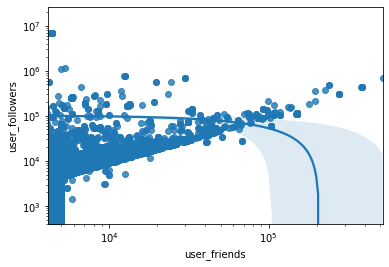

In [32]:
sns.regplot(x="user_friends", y="user_followers", data=data)
plt.xscale('log')
plt.yscale('log')

In [33]:
data[['user_followers', 'positive']].corr()


user_followers  positive
user_followers        1.000000 -0.017772
positive             -0.017772  1.000000

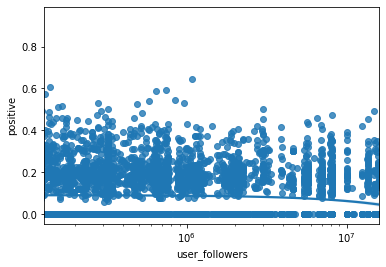

In [34]:
sns.regplot(x="user_followers", y="positive", data=data)
plt.xscale('log')

In [35]:
data[['user_friends', 'compound']].corr()

user_friends  compound
user_friends      1.000000  0.002227
compound          0.002227  1.000000

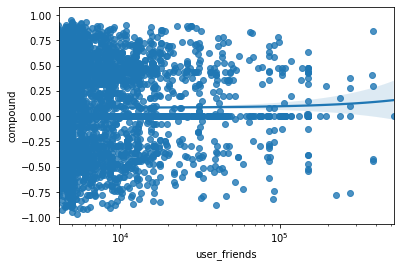

In [36]:
sns.regplot(x="user_friends", y="compound", data=data)
plt.xscale('log')

<AxesSubplot:xlabel='positive', ylabel='compound'>

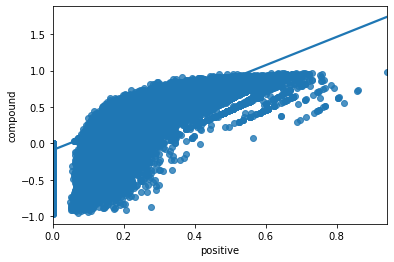

In [37]:
sns.regplot(x="positive", y="compound", data=data)

<AxesSubplot:xlabel='negative', ylabel='compound'>

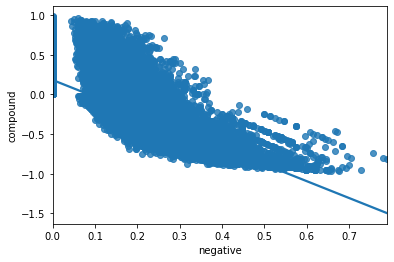

In [38]:
sns.regplot(x="negative", y="compound", data=data)

<AxesSubplot:xlabel='neutral', ylabel='compound'>

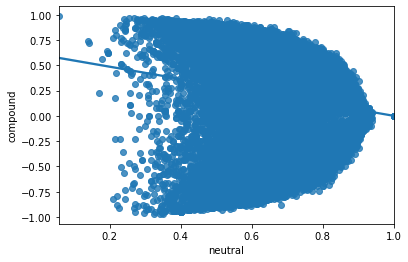

In [39]:
sns.regplot(x="neutral", y="compound", data=data)

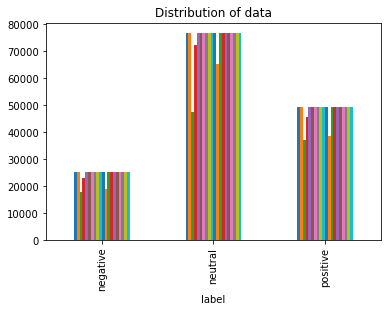

In [40]:
# Plotting the distribution for dataset.
ax = data.groupby('label').count().plot(kind='bar', title='Distribution of data',legend=False)
# Storing data in lists.
text, sentiment = list(data['text']), list(data['label'])

<AxesSubplot:xlabel='label', ylabel='count'>

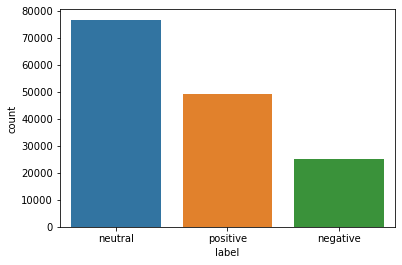

In [41]:
sns.countplot(x='label', data=data, order = data['label'].value_counts().index)

In [42]:
#seperating positive, neutral and negative tweets
data_pos=data[data['label']=='positive']
data_neg=data[data['label']=='negative']
data_neu=data[data['label']=='neutral']

In [43]:
data_pos.head()

id            user_name                user_location  \
0  1340539111971516416           Rachel Roh    La Crescenta-Montrose, CA   
2  1337858199140118533             eli🇱🇹🇪🇺👌                     Your Bed   
5  1337852648389832708                  Dee          Birmingham, England   
6  1337851215875608579    Gunther Fehlinger  Austria, Ukraine and Kosovo   
7  1337850832256176136  Dr.Krutika Kuppalli                          NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
5  Gastroenterology trainee, Clinical Research Fe...  2020-01-26 21:43:12   
6  End North Stream 2 now - the pipeline of corru...  2013-06-10 17:49:22   
7  ID, Global Health, VHF, Pandemic Prep, Emergin...  2019-03-25 04:14:29   

   user_followers  user_friends  user_favourites  user_verified        date  \
0             405          1692             3247          False  2020-12-20   
2              10            88              155          False  2020-12-12   
5             105           108              106          False  2020-12-12   
6            2731          5001            69344          False  2020-12-12   
7           21924           593             7815           True  2020-12-12   

   ...                                           hashtags  \
0  ...                                 ['PfizerBioNTech']   
2  ...  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...   
5  ...                                                NaN   
6  ...                                    ['vaccination']   
7  ...                    ['BidenHarris', 'Election2020']   

                source retweets  favorites  is_retweet  positive  negative  \
0  Twitter for Android        0          0       False     0.213     0.000   
2  Twitter for Android        0          0       False     0.154     0.000   
5   Twitter for iPhone        0          0       False     0.392     0.000   
6      Twitter Web App        0          4       False     0.335     0.157   
7   Twitter for iPhone        2         22       False     0.517     0.085   

   neutral  compound     label  
0    0.787    0.4019  positive  
2    0.846    0.2500  positive  
5    0.608    0.7003  positive  
6    0.508    0.5423  positive  
7    0.398    0.8933  positive  

[5 rows x 21 columns]

In [44]:
#Sperarating input feature and label
X=data.text
y=data.label

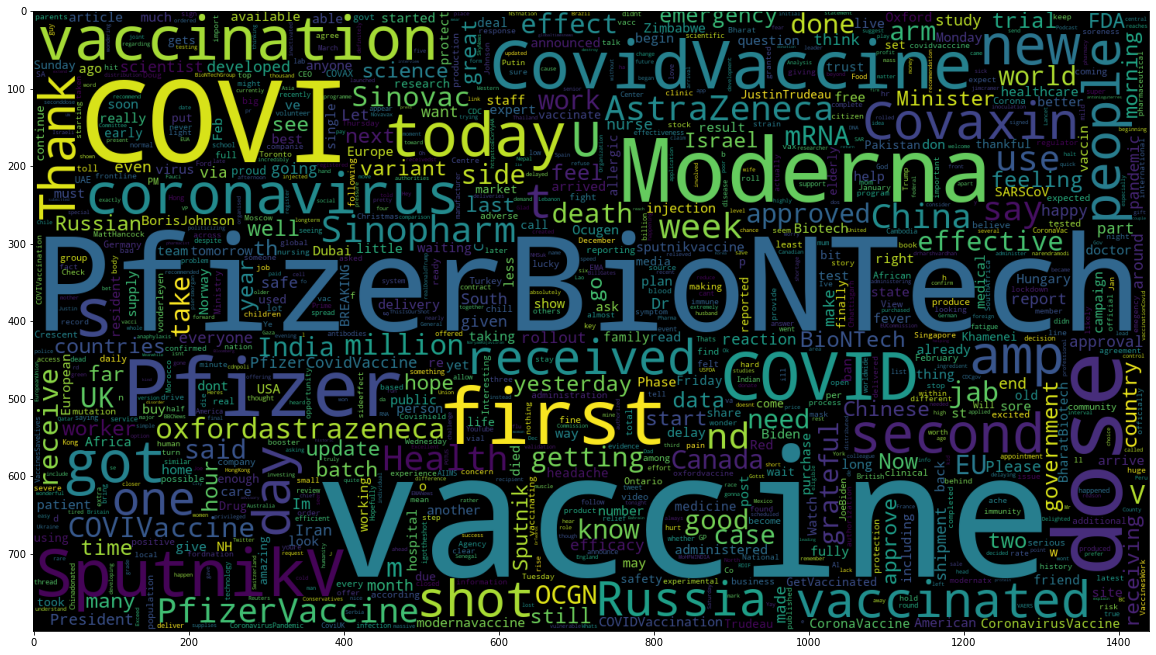

In [45]:
#Plot a cloud of words for negative tweets
data_neg1 = data['text'][:10000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1440 , height = 800,
               collocations=False).generate(" ".join(data_neg1))
plt.imshow(wc)

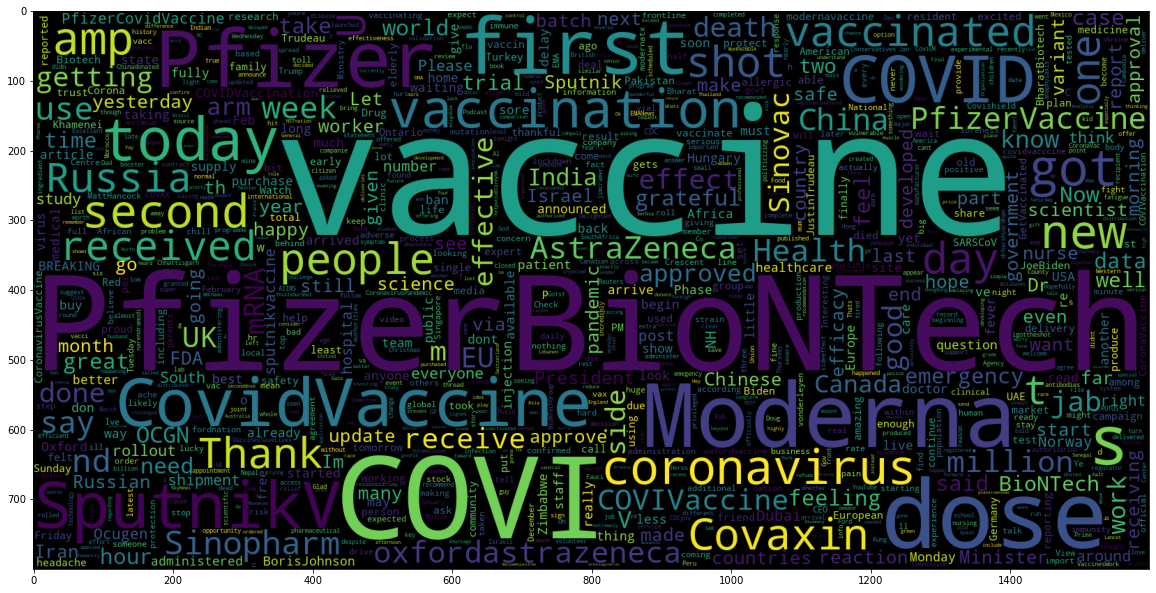

In [46]:
#Plot a cloud of words for positive tweets
data_pos = data['text'][:10000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

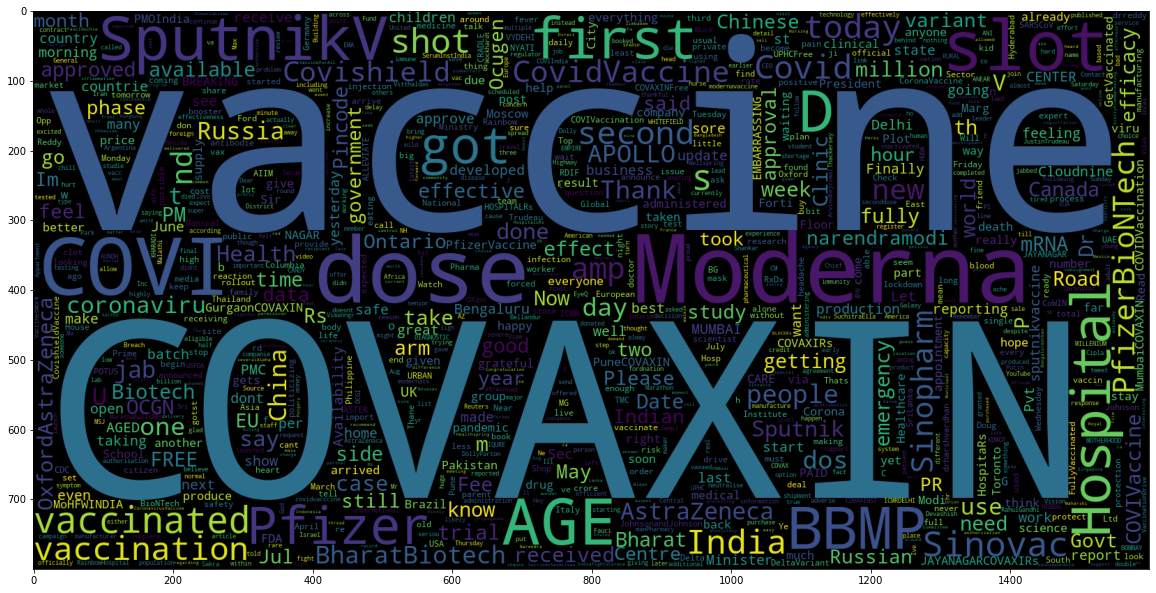

In [47]:
#Plot a cloud of words for neutral tweets
data_neu = data['text'][:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neu))
plt.imshow(wc)

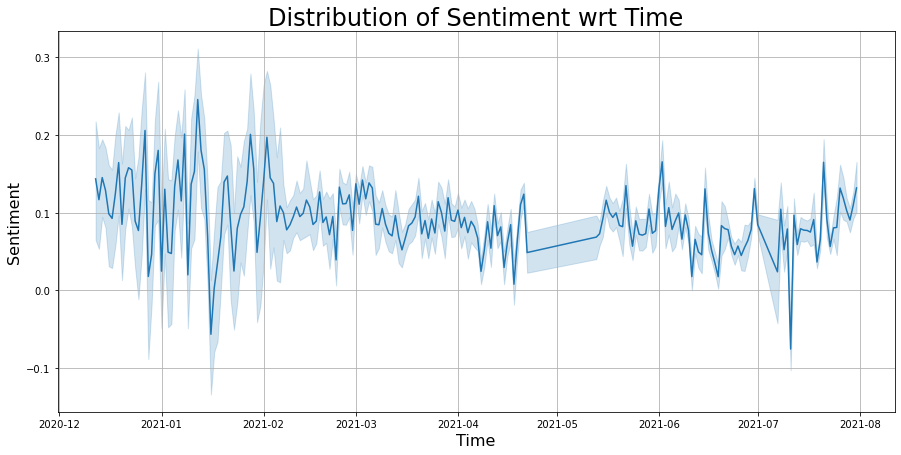

In [48]:
fg,axs=plt.subplots(figsize=(15,7))
sns.lineplot(ax=axs,x='date',y='compound', data= data)
axs.set_xlabel("Time",size=16)
axs.set_ylabel("Sentiment",size=16)
axs.set_title("Distribution of Sentiment wrt Time",size=24)
axs.grid()

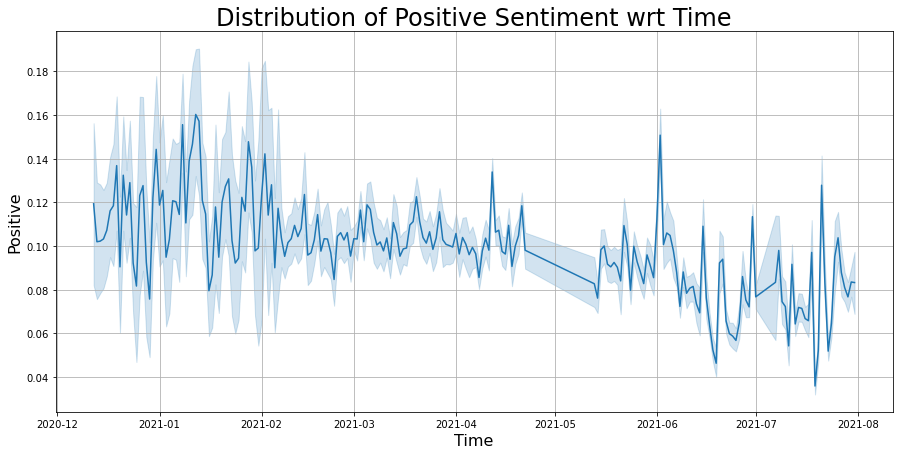

In [49]:
fg,axs=plt.subplots(figsize=(15,7))
sns.lineplot(ax=axs,x='date',y='positive', data= data)
axs.set_xlabel("Time",size=16)
axs.set_ylabel("Positive",size=16)
axs.set_title("Distribution of Positive Sentiment wrt Time",size=24)
axs.grid()

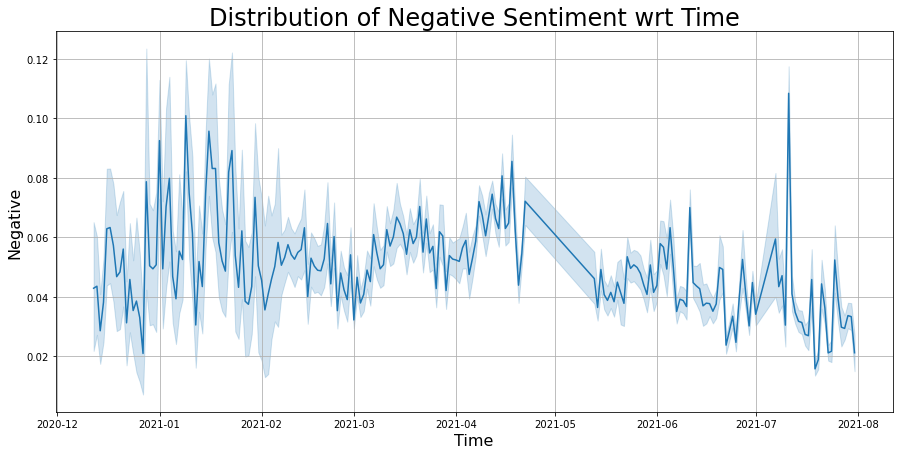

In [50]:
fg,axs=plt.subplots(figsize=(15,7))
sns.lineplot(ax=axs,x='date',y='negative', data= data)
axs.set_xlabel("Time",size=16)
axs.set_ylabel("Negative",size=16)
axs.set_title("Distribution of Negative Sentiment wrt Time",size=24)
axs.grid()

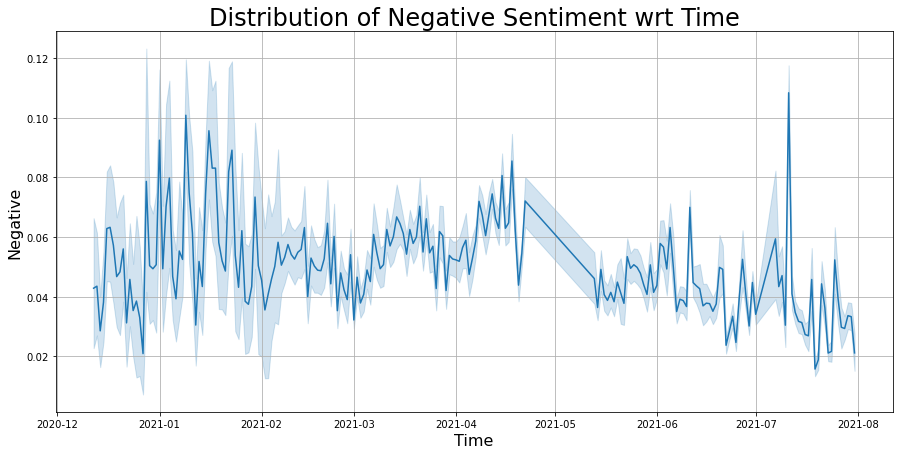

In [51]:
fg,axs=plt.subplots(figsize=(15,7))
sns.lineplot(ax=axs,x='date',y='negative', data= data)
axs.set_xlabel("Time",size=16)
axs.set_ylabel("Negative",size=16)
axs.set_title("Distribution of Negative Sentiment wrt Time",size=24)
axs.grid()

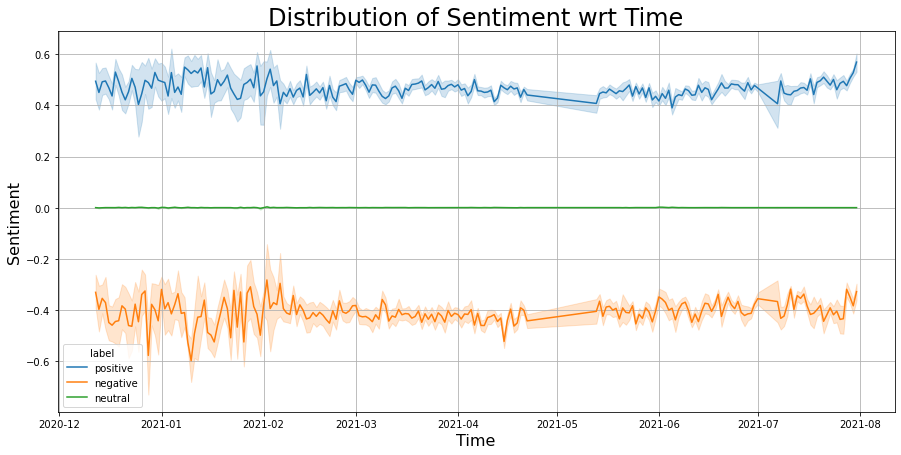

In [52]:
fg,axs=plt.subplots(figsize=(15,7))
sns.lineplot(ax=axs,x='date',y='compound', hue='label', data= data)
axs.set_xlabel("Time",size=16)
axs.set_ylabel("Sentiment",size=16)
axs.set_title("Distribution of Sentiment wrt Time",size=24)
axs.grid()

In [53]:
# Separating the 80% data for training data and 20% for testing data (data into Train and Test Subset)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =26105111)

In [54]:
#Transforming Dataset using TF-IDF Vectorizer - Fit the TF-IDF Vectorizer to extract features from cleaned dataset
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [55]:
#Transform the data using TF-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

## Function For Model Evaluation

In [56]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive', 'Neutral']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [57]:
X_train

<120791x500000 sparse matrix of type '<class 'numpy.float64'>'
	with 2344205 stored elements in Compressed Sparse Row format>

              precision    recall  f1-score   support

    negative       0.95      0.23      0.38      4994
     neutral       0.77      0.95      0.85     15342
    positive       0.76      0.76      0.76      9862

    accuracy                           0.77     30198
   macro avg       0.83      0.65      0.66     30198
weighted avg       0.79      0.77      0.74     30198



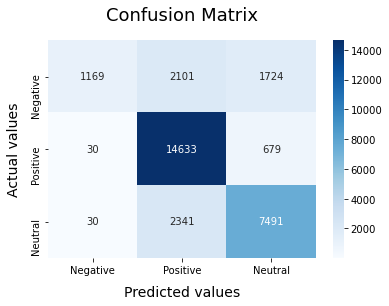

In [58]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

              precision    recall  f1-score   support

    negative       0.87      0.66      0.75      4994
     neutral       0.86      0.97      0.91     15342
    positive       0.90      0.84      0.87      9862

    accuracy                           0.87     30198
   macro avg       0.88      0.82      0.84     30198
weighted avg       0.88      0.87      0.87     30198



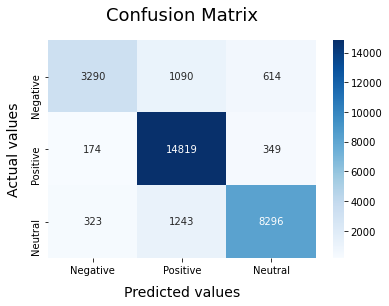

In [59]:
#Multiclass logistic Regression Using OVR (One Vs Rest algorithm)
from sklearn import linear_model
LRmodel = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
LRmodel.fit(X_train, y_train)
LRmodel.score(X_test, y_test)
model_Evaluate(LRmodel)
y_pred2 = LRmodel.predict(X_test)

#logistic Regression (with only two class)
#LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
#LRmodel.fit(X_train, y_train)
#model_Evaluate(LRmodel)
#y_pred2 = LRmodel.predict(X_test)

              precision    recall  f1-score   support

    negative       0.89      0.80      0.84      4994
     neutral       0.94      0.97      0.95     15342
    positive       0.92      0.92      0.92      9862

    accuracy                           0.92     30198
   macro avg       0.92      0.90      0.91     30198
weighted avg       0.92      0.92      0.92     30198



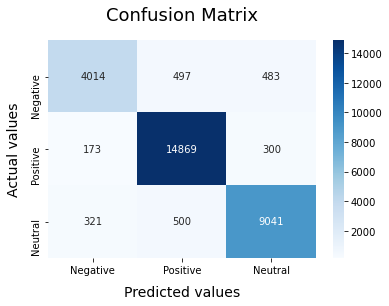

In [60]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred3 = SVCmodel.predict(X_test)

## Repeating the same process but with new train test dataset (70:30)

In [61]:
# Separating the 70% data for training data and 30% for testing data (data into Train and Test Subset)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state =26105111)

In [62]:
#Transforming Dataset using TF-IDF Vectorizer - Fit the TF-IDF Vectorizer to extract features from cleaned dataset
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [63]:
#Transform the data using TF-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [64]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive', 'Neutral']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

    negative       0.97      0.20      0.34      7471
     neutral       0.74      0.96      0.84     23072
    positive       0.77      0.72      0.74     14754

    accuracy                           0.76     45297
   macro avg       0.83      0.63      0.64     45297
weighted avg       0.79      0.76      0.72     45297



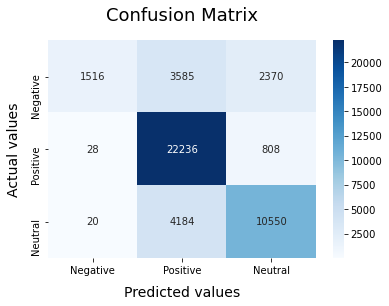

In [65]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

              precision    recall  f1-score   support

    negative       0.87      0.64      0.73      7471
     neutral       0.86      0.97      0.91     23072
    positive       0.89      0.83      0.86     14754

    accuracy                           0.87     45297
   macro avg       0.87      0.81      0.83     45297
weighted avg       0.87      0.87      0.86     45297



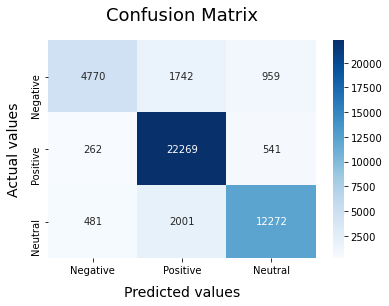

In [66]:
#Multiclass logistic Regression Using OVR (One Vs Rest algorithm)
from sklearn import linear_model
LRmodel = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
LRmodel.fit(X_train, y_train)
LRmodel.score(X_test, y_test)
model_Evaluate(LRmodel)
y_pred2 = LRmodel.predict(X_test)

#logistic Regression (with only two class)
#LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
#LRmodel.fit(X_train, y_train)
#model_Evaluate(LRmodel)
#y_pred2 = LRmodel.predict(X_test)

              precision    recall  f1-score   support

    negative       0.89      0.80      0.84      7471
     neutral       0.93      0.97      0.95     23072
    positive       0.92      0.91      0.92     14754

    accuracy                           0.92     45297
   macro avg       0.91      0.89      0.90     45297
weighted avg       0.92      0.92      0.92     45297



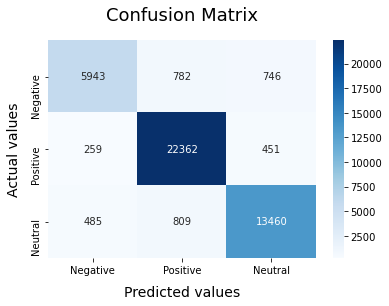

In [67]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred3 = SVCmodel.predict(X_test)

In [68]:
clf = DecisionTreeClassifier() 

In [69]:
clf = clf.fit(X_train, y_train)

In [70]:
text_rep = tree.export_text(clf)
print(text_rep)

|--- feature_89274 <= 0.07
|   |--- feature_257768 <= 0.06
|   |   |--- feature_408411 <= 0.04
|   |   |   |--- feature_174495 <= 0.04
|   |   |   |   |--- feature_142094 <= 0.05
|   |   |   |   |   |--- feature_28997 <= 0.04
|   |   |   |   |   |   |--- feature_200903 <= 0.03
|   |   |   |   |   |   |   |--- feature_179266 <= 0.04
|   |   |   |   |   |   |   |   |--- feature_409269 <= 0.04
|   |   |   |   |   |   |   |   |   |--- feature_146279 <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- feature_298389 <= 0.09
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 1639
|   |   |   |   |   |   |   |   |   |   |--- feature_298389 >  0.09
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 54
|   |   |   |   |   |   |   |   |   |--- feature_146279 >  0.07
|   |   |   |   |   |   |   |   |   |   |--- feature_437645 <= 0.14
|   |   |   |   |   |   |   |   |   |   |   |--- class: negative
|   |   |   |   |   |   |   |   |   |   |--- featur